Master 2 MVA - Computational Statistics
TP3 : Hasting-Metropolis (and Gibbs) samplers

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invwishart, invgamma, norm, cauchy
import seaborn as sns
import pandas as pd
from numba import njit
from scipy.stats import probplot


Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM


1.A – A population model for longitudinal data

In [71]:
np.random.seed(10)

#Generate synthetic data from the model by taking some reasonable values for the parameters
sigma_t0 = 0.1
sigma_v0 = 0.1

s_t0 = 0.1
s_v0 = 0.1

t0_bb = 1
v0_bb = 1

m = np.random.randint(5,11)
v = np.random.rand()*4 +1 

#Number of individuals
N = 100
#Number of points per individual
k_individual = 20


In [72]:
np.random.seed(10)


def t0_b_f(n,t0_bb,s_t0):
    return np.random.normal(t0_bb,s_t0,n)

def v0_b_f(n,v0_bb,s_v0):
    return np.random.normal(v0_bb,s_v0,n)

def inverse_gamma(n,v,m):
    return invwishart.rvs(df=m, scale=v**2,size=n)

def tau_i_f(n,v,m):
    sigma_carre = inverse_gamma(n,v,m)
    return np.random.normal(0,np.sqrt(sigma_carre),n)

def xi_i_f(n,v,m):
    sigma_carre = inverse_gamma(n,v,m)
    return np.random.normal(0,np.sqrt(sigma_carre),n)

# def alpha_i(n,v,m):
#     return np.exp(ksi_i(n,v,m))

def espilon_ij(n,v,m):
    sigma_carre = inverse_gamma(n,v,m)
    return np.random.normal(0,np.sqrt(sigma_carre),n)

#def y_ij()

def t0_f(n,t0_b,sigma_t0):
    return np.random.normal(t0_b,sigma_t0,n)

def v0_f(n,v0_b,sigma_v0):
    return np.random.normal(v0_b,sigma_v0,n)

In [73]:
np.random.seed(500)

t0_b = t0_b_f(1,t0_bb,s_t0)
t0 = t0_f(1,t0_b,sigma_t0)

v0_b = v0_b_f(1,v0_bb,s_v0)
v0 = v0_f(1,v0_b,sigma_v0)

xi = xi_i_f(N,v,m)
tau = tau_i_f(N,v,m)
alpha = np.exp(xi)

sigma_xi = inverse_gamma(1,v,m)
sigma_tau = inverse_gamma(1,v,m)
sigma = inverse_gamma(1,v,m)

In [74]:
real_z = np.concatenate((t0,v0,xi,tau),axis=0)
#Real theta
real_theta = np.array([t0_b[0],v0_b[0],sigma_xi,sigma_tau,sigma])

In [75]:
real_theta

array([0.96226364, 1.06828024, 1.09811226, 1.29905008, 1.26838235])

In [76]:
real_z

array([ 9.78939534e-01,  1.26041811e+00,  9.72455641e-01,  5.60168182e-01,
       -1.04550074e+00,  3.87810051e-01,  1.55459086e+00, -5.15750742e-01,
       -1.24656517e-01, -6.25086403e-01, -2.15584869e-01,  5.85943151e-01,
        8.22349599e-02,  1.42543948e+00, -6.80003647e-01, -2.08171775e-01,
       -1.35165576e+00,  5.80991551e-01, -4.09762781e-01, -3.05866202e-02,
       -1.34263495e+00,  9.58396124e-01,  3.26839182e-01,  1.06022913e+00,
       -3.17870318e-01,  1.86853852e+00,  1.33903318e+00,  7.70018482e-01,
        1.26921082e-01,  1.48493209e+00, -7.48506443e-01,  1.25126343e+00,
       -8.71964631e-01, -1.66113259e-01, -4.76905619e-01, -1.01707800e-01,
        9.04152012e-02,  3.95029973e-01, -1.57802429e+00, -1.61191564e-01,
       -8.81572205e-02,  2.18473185e+00,  1.18049839e-01, -6.12020433e-01,
        3.10783376e-02, -2.53300275e+00,  8.83375994e-01,  4.34088623e-01,
       -3.52499074e-01,  3.78103532e-01, -6.03600999e-01, -5.11809834e-02,
       -5.58719033e-01,  

In [78]:
@njit
def d_mean(t,t0,v0):
    return v0 * (t - t0)

@njit
def d_function(t,alpha_i,t0,tau_i):
    param = alpha_i * (t - t0 - tau_i) + t0
    return d_mean(param,t0,v0)

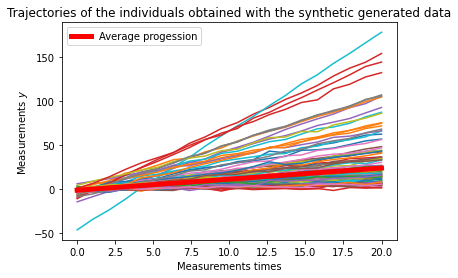

In [79]:
np.random.seed(0)

t = np.linspace(0,k_individual,k_individual)

d_m = d_mean(t,t0,v0)


# d_i = np.zeros((N,k))
# y_i = np.zeros((N,k))

# for i in range(N):
#     d_i[i,:] = d(t,alpha[i],t0,tau[i])
#     y_i[i,:] = d_i[i,:] + espilon_ij(k,v,m)
#     plt.plot(t,y_i[i,:])



d_i = d_function(t,alpha.reshape(-1,1),t0,tau.reshape(-1,1))
y_i = d_i + espilon_ij(k_individual*N,v,m).reshape(N,k_individual)

#We exclude one outlier for a better visualization of the graph
for i in range(N):
    if i!=64 :
        plt.plot(t,y_i[i,:])

plt.plot(t,d_m,color='red',label="Average progession",linewidth=5)

# Customize the plot
plt.xlabel('Measurements times')
plt.ylabel(r'Measurements $y$')
plt.title('Trajectories of the individuals obtained with the synthetic generated data')
plt.legend()  # Add a legend to differentiate between rows

# Show the plot

plt.show()

In [80]:
@njit
def mult_gaussian_distribution(sigma_propre,d):
    return np.random.normal(0,sigma_propre,d)

In [82]:
@njit
def S_function(y,z):
    S_t0 = z[0]
    S_v0 = z[1]
    S_xi = z[2:(N+2)]
    S_tau = z[(N+2):]
    S_alpha = np.exp(S_xi)

    d_ij = d_function(t,S_alpha.reshape(-1,1),t0,S_tau.reshape(-1,1))

    S5 = np.mean((y-d_ij)**2) 
    S6 = -(1/2) * ( (S_t0/sigma_t0)**2  +  (S_v0/sigma_v0)**2 )

    return np.array([S_t0,S_v0,np.mean(S_xi**2),np.mean(S_tau**2),S5,S6])


In [84]:
@njit
def psi(theta):
    psi_1 = theta[0] / (sigma_t0**2)
    psi_2 = theta[1] / (sigma_v0**2)
    psi_3 = - N / (2*(sigma_xi**2))
    psi_4 = - N / (2*(sigma_tau**2))
    psi_5 = - N*k_individual / (2*(sigma**2))
    psi_6 = 1

    return np.array([psi_1,psi_2,psi_3,psi_4,psi_5,psi_6])

In [248]:
# @njit
# def log_posterior(z,t0_b,v0_b,sigma_ksi,sigma_tau):
#     zt0 = z[0]
#     zv0 = z[1]
#     zksi = z[2:(N+2)]
#     ztau = z[(N+2):]
#     log_t0 = -(1/2) * ((zt0 - t0_b)/sigma_t0)**2 - np.log(sigma_t0)
#     log_v0 = -(1/2) * ((zv0 - v0_b)/sigma_v0)**2 - np.log(sigma_v0)
#     log_ksi_i = -(1/2) * (zksi/sigma_ksi)**2 - np.log(sigma_ksi)
#     log_tau_i = -(1/2) * (ztau/sigma_tau)**2 - np.log(sigma_tau)

#     log_post = log_t0 + log_v0 + np.sum(log_ksi_i) + np.sum(log_tau_i)

#     return log_post

In [86]:
@njit
def MH_sampler(y,z_init,max_iter,sigma_propre,theta):

    z = z_init
    d = z.size
    nb_accepte = 0
    z_run = np.zeros((max_iter,d))
    z_run[0,:] = z
  
    for k in range(max_iter):
        z_star = z + np.random.normal(0,sigma_propre,d)
        #log_ratio = log_posterior(z_star,t0_b,v0_b,sigma_ksi,sigma_tau) - log_posterior(z,t0_b,v0_b,sigma_ksi,sigma_tau)
        log_ratio = np.dot((S_function(y,z_star) - S_function(y,z)),psi(theta))
        u = np.random.rand()
        if np.log(u) < min(0,log_ratio):
            z = z_star
            nb_accepte+=1
        z_run[k,:] = z
    return z, (nb_accepte/max_iter), z_run


In [89]:
np.random.seed(0)
#We generate a run given the real theta
z, acceptation_rate, z_run = MH_sampler(y_i,np.zeros(2*N+2),50000,0.001,real_theta)

In [90]:
#Acceptatio rate between 0.2 and 0.4
acceptation_rate

0.3283

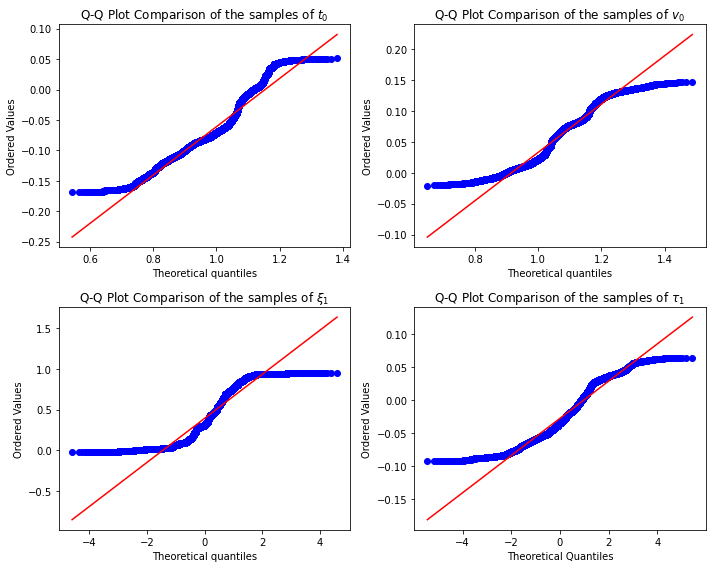

In [93]:
length_run = z_run.shape[0]
t0_run = z_run[:,0]
v0_run = z_run[:,1]
xi_1_run = z_run[:,2]
tau_1_run = z_run[:,N+2]
# Create a figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Create Q-Q plots
qq_plot_t0 = probplot(t0_run, dist='norm', sparams=(t0_b, sigma_t0),plot=axs[0,0])
qq_plot_v0 = probplot(v0_run, dist='norm', sparams=(v0_b, sigma_v0),plot=axs[0,1])
qq_plot_xi_1 = probplot(xi_1_run, dist='norm', sparams=(0, sigma_xi),plot=axs[1,0])
qq_plot_tau_1 = probplot(tau_1_run, dist='norm', sparams=(0, sigma_tau),plot=axs[1,1])


axs[0,0].set_title(r'Q-Q Plot Comparison of the samples of $t_0$')
axs[0,1].set_title(r'Q-Q Plot Comparison of the samples of $v_0$')
axs[1,0].set_title(r'Q-Q Plot Comparison of the samples of $\xi_1$')
axs[1,1].set_title(r'Q-Q Plot Comparison of the samples of $\tau_1$')
# Add labels and title
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [94]:
init_theta = np.array([0.,0.,1.,1.,1.])

In [116]:
#Implement HM-SAEM
@njit
def HM_SAEM(y,theta_init,z_init,max_iter,N_b,alph_burn,sigma_propre,MH_steps):
    #Initialization
    S = np.zeros(6)
    step_sizes = np.ones(max_iter)
    step_sizes[(N_b+1):] = 1/((np.arange(N_b+1,max_iter) - N_b)**alph_burn)

    theta = theta_init
    z = z_init

    thetas = np.zeros((max_iter+1,5))
    thetas[0,:] = theta

    for k in range(max_iter):
        #Expectation step
        
        z, acceptation_rate,_ = MH_sampler(y,z,MH_steps,sigma_propre,theta)
        
        print("Acceptation rate : ",acceptation_rate)
        
        S += step_sizes[k] * ( S_function(y,z) - S)
       

        #Maximization step
        log_t0_b = np.log(S[0]/(sigma_t0**2) + t0_bb/(s_t0**2) ) - np.log( 1/(s_t0**2) + 1/(sigma_t0**2)  )
        log_v0_b = np.log(S[1]/(sigma_v0**2) + v0_bb/(s_v0**2) ) - np.log( 1/(s_v0**2) + 1/(sigma_v0**2)  )
        log_sigma_ksi = (1/2) * ( np.log(v**2 + S[2]*N ) - np.log(m+2+N)  )
        log_sigma_tau = (1/2) * ( np.log(v**2 + S[3]*N ) - np.log(m+2+N)  )
        log_sigma = (1/2) * ( np.log(v**2 + S[4]*N*k_individual) - np.log(m+2+N*k_individual)  )
        # local_t0_b = (S[0]/(sigma_t0**2) + t0_bb/(s_t0**2)) / (1/(s_t0**2) + 1/(sigma_t0**2))
        # local_v0_b = (S[1]/(sigma_v0**2) + v0_bb/(s_v0**2)) / (1/(s_v0**2) + 1/(sigma_v0**2))
        # local_sigma_ksi = np.sqrt( (v**2 + S[2]*N )  / (m+2+N) )
        # local_sigma_tau = np.sqrt( (v**2 + S[3]*N )  / (m+2+N) )
        # local_sigma = np.sqrt( (v**2 + S[4]*N*k_individual )  / (m+2+N*k_individual) )

        #theta = np.array([local_t0_b,local_v0_b,local_sigma_ksi,local_sigma_tau,local_sigma])
       
        theta = np.exp(np.array([log_t0_b,log_v0_b,log_sigma_ksi,log_sigma_tau,log_sigma]))

        thetas[(k+1),:] = theta
    
    return theta, thetas



In [117]:
np.random.seed(0)
estimated_theta, thetas = HM_SAEM(y_i,init_theta,np.zeros(2*N+2),10000,2500,0.75,1e-3,500)

Acceptation rate :  0.51
Acceptation rate :  0.5
Acceptation rate :  0.532
Acceptation rate :  0.502
Acceptation rate :  0.488
Acceptation rate :  0.484
Acceptation rate :  0.502
Acceptation rate :  0.498
Acceptation rate :  0.508
Acceptation rate :  0.494
Acceptation rate :  0.516
Acceptation rate :  0.492
Acceptation rate :  0.484
Acceptation rate :  0.526
Acceptation rate :  0.474
Acceptation rate :  0.536
Acceptation rate :  0.53
Acceptation rate :  0.51
Acceptation rate :  0.514
Acceptation rate :  0.506
Acceptation rate :  0.516
Acceptation rate :  0.476
Acceptation rate :  0.48
Acceptation rate :  0.494
Acceptation rate :  0.502
Acceptation rate :  0.488
Acceptation rate :  0.46
Acceptation rate :  0.358
Acceptation rate :  0.366
Acceptation rate :  0.352
Acceptation rate :  0.338
Acceptation rate :  0.304
Acceptation rate :  0.29
Acceptation rate :  0.302
Acceptation rate :  0.306
Acceptation rate :  0.344
Acceptation rate :  0.326
Acceptation rate :  0.324
Acceptation rate :  

In [118]:
np.linalg.norm(real_theta-estimated_theta)

0.5007657664797047

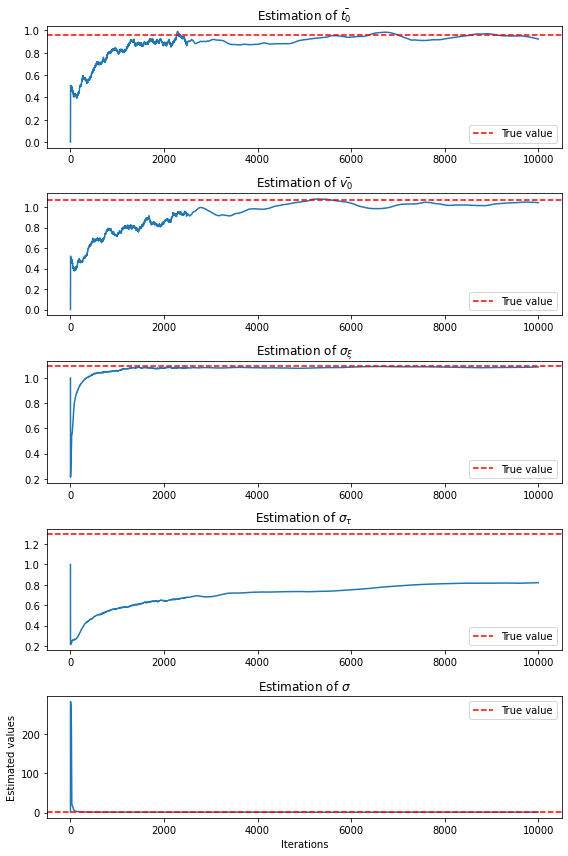

In [121]:
t0_b_est = thetas[:,0]
v0_b_est = thetas[:,1]
sigma_xi_est = thetas[:,2]
sigma_tau_est = thetas[:,3]
sigma_est = thetas[:,4]

iterations = thetas.shape[0]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 12))
abscisse = np.arange(iterations)



# Create Q-Q plots
plot_t0 = axs[0].plot(abscisse,t0_b_est)
plot_v0 = axs[1].plot(abscisse,v0_b_est)
plot_sigma_xi = axs[2].plot(abscisse,sigma_xi_est)
plot_sigma_tau = axs[3].plot(abscisse,sigma_tau_est)
plot_sigma = axs[4].plot(abscisse,sigma_est)


axs[0].set_title(r'Estimation of $\bar{t_0}$')
axs[1].set_title(r'Estimation of $\bar{v_0}$')
axs[2].set_title(r'Estimation of $\sigma_{\xi}$')
axs[3].set_title(r'Estimation of $\sigma_{\tau}$')
axs[4].set_title(r'Estimation of $\sigma$')


# Add horizontal lines for true values
axs[0].axhline(y=t0_b[0], color='red', linestyle='--', label='True value')
axs[1].axhline(y=v0_b[0], color='red', linestyle='--', label='True value')
axs[2].axhline(y=sigma_xi, color='red', linestyle='--', label='True value')
axs[3].axhline(y=sigma_tau, color='red', linestyle='--', label='True value')
axs[4].axhline(y=sigma, color='red', linestyle='--', label='True value')


# Add legend
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Estimated values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

1.C – HMwG-SAEM – Hasting-Metropolis within Gibbs sampler

In [138]:
np.random.seed(0)
@njit
def MHwG_zi(zi,z_pop,y,theta,max_iter,sigma_propre):
    
    taux_acceptation = np.zeros(2*N)

    z = np.concatenate((z_pop,zi))

    for l in range(2*N):

        accepte = 0
        z_l = np.copy(z)

        for k in range(max_iter):
            z_l[2+l] = z[2+l] + np.random.normal(0,sigma_propre)
        
            log_ratio = np.dot((S_function(y,z_l) - S_function(y,z)),psi(theta))
            
            u = np.random.rand()
            if np.log(u) < min(0,log_ratio):
                z[l+2] = z_l[l+2]
                accepte+=1
        
        taux_acceptation[l] = accepte / max_iter

    return z[2:], taux_acceptation

In [140]:
np.random.seed(0)
@njit
def MHwG_zpop(zi,z_pop,y,theta,max_iter,sigma_propre):
    
    taux_acceptation = np.zeros(2)

    z = np.concatenate((z_pop,zi))

    for l in range(2):

        accepte = 0
        z_l = np.copy(z)

        for k in range(max_iter):
            z_l[l] = z[l] + np.random.normal(0,sigma_propre)
        
            log_ratio = np.dot((S_function(y,z_l) - S_function(y,z)),psi(theta))
            
            u = np.random.rand()
            if np.log(u) < min(0,log_ratio):
                z[l] = z_l[l]
                accepte+=1
        
        taux_acceptation[l] = accepte / max_iter

    return z[:2], taux_acceptation

In [124]:
np.random.seed(0)
z_i, accept_rate_zi = MHwG_zi(np.zeros(2*N),real_z[:2],y_i,real_theta,10000,0.05)

In [125]:
accept_rate_zi

array([0.1961, 0.2736, 0.72  , 0.3058, 0.1319, 0.5689, 0.5436, 0.6127,
       0.5202, 0.2649, 0.3882, 0.119 , 0.6587, 0.5004, 0.8105, 0.2808,
       0.5606, 0.4643, 0.8104, 0.1881, 0.3173, 0.1688, 0.5709, 0.0826,
       0.1403, 0.2653, 0.4195, 0.1234, 0.6288, 0.1487, 0.6628, 0.575 ,
       0.5816, 0.4716, 0.4307, 0.3169, 0.8635, 0.4783, 0.4406, 0.0765,
       0.4255, 0.6343, 0.4274, 0.927 , 0.1724, 0.3245, 0.5168, 0.334 ,
       0.6378, 0.4834, 0.6174, 0.1611, 0.797 , 0.9489, 0.4764, 0.8758,
       0.5811, 0.8134, 0.2714, 0.7122, 0.2117, 0.509 , 0.7526, 0.0951,
       0.0178, 0.4103, 0.5716, 0.2137, 0.8061, 0.1461, 0.7425, 0.7422,
       0.2901, 0.4213, 0.8194, 0.5862, 0.7955, 0.2575, 0.7865, 0.3482,
       0.5191, 0.2668, 0.1694, 0.4785, 0.8182, 0.7863, 0.8323, 0.3818,
       0.1198, 0.6095, 0.3558, 0.5414, 0.8033, 0.5942, 0.0944, 0.6183,
       0.3375, 0.8232, 0.1936, 0.4457, 0.8233, 0.8687, 0.9678, 0.8904,
       0.7161, 0.9539, 0.9468, 0.955 , 0.944 , 0.8701, 0.9192, 0.7106,
      

In [127]:
z_pop, accept_rate_zpop = MHwG_zpop(real_z[2:],np.zeros(2),y_i,real_theta,10000,0.4)

In [128]:
accept_rate_zpop

array([0.2891, 0.2921])

In [141]:
np.random.seed(0)
@njit
def HMwG_SAEM(y,theta_init,z_init,max_iter,N_b,alph_burn,sigma_propre,MH_steps):
    #Initialization
    S = np.zeros(6)
    step_sizes = np.ones(max_iter)
    step_sizes[(N_b+1):] = 1/((np.arange(N_b+1,max_iter) - N_b)**alph_burn)

    theta = theta_init
    z = z_init

    thetas = np.zeros((max_iter+1,5))
    thetas[0,:] = theta
    

    for k in range(max_iter):
        #Expectation step
        
        zpop,zi = z[:2],z[2:]
        zpop, accept_rate_zpop = MHwG_zpop(zi,zpop,y,theta,MH_steps,sigma_propre)
        zi, accept_rate_zi = MHwG_zi(zi,zpop,y,theta,MH_steps,sigma_propre)
        print("Mean acceptation rate for zi : ",np.mean(accept_rate_zi))
        print("Mean acceptation rate for zpop : ",np.mean(accept_rate_zpop))
        z = np.concatenate((zpop,zi))

        
        S += step_sizes[k] * ( S_function(y,z) - S)

        #Maximization step
        log_t0_b = np.log(S[0]/(sigma_t0**2) + t0_bb/(s_t0**2) ) - np.log( 1/(s_t0**2) + 1/(sigma_t0**2)  )
        log_v0_b = np.log(S[1]/(sigma_v0**2) + v0_bb/(s_v0**2) ) - np.log( 1/(s_v0**2) + 1/(sigma_v0**2)  )
        log_sigma_ksi = (1/2) * ( np.log(v**2 + S[2]*N ) - np.log(m+2+N)  )
        log_sigma_tau = (1/2) * ( np.log(v**2 + S[3]*N ) - np.log(m+2+N)  )
        log_sigma = (1/2) * ( np.log(v**2 + S[4]*N*k_individual) - np.log(m+2+N*k_individual)  )
        # local_t0_b = (S[0]/(sigma_t0**2) + t0_bb/(s_t0**2)) / (1/(s_t0**2) + 1/(sigma_t0**2))
        # local_v0_b = (S[1]/(sigma_v0**2) + v0_bb/(s_v0**2)) / (1/(s_v0**2) + 1/(sigma_v0**2))
        # local_sigma_ksi = np.sqrt( (v**2 + S[2]*N )  / (m+2+N) )
        # local_sigma_tau = np.sqrt( (v**2 + S[3]*N )  / (m+2+N) )
        # local_sigma = np.sqrt( (v**2 + S[4]*N*k_individual )  / (m+2+N*k_individual) )

        #theta = np.array([local_t0_b,local_v0_b,local_sigma_ksi,local_sigma_tau,local_sigma])
        
        theta = np.exp(np.array([log_t0_b,log_v0_b,log_sigma_ksi,log_sigma_tau,log_sigma]))
        thetas[(k+1),:] = theta
    
    return theta , thetas

In [146]:
np.random.seed(0)
estimated_theta, thetas = HMwG_SAEM(y_i,init_theta,np.zeros(2*N+2),500,50,0.75,0.3,20)

Mean acceptation rate for zi :  0.45075000000000004
Mean acceptation rate for zpop :  0.4
Mean acceptation rate for zi :  0.37450000000000006
Mean acceptation rate for zpop :  0.475
Mean acceptation rate for zi :  0.364
Mean acceptation rate for zpop :  0.475
Mean acceptation rate for zi :  0.37225
Mean acceptation rate for zpop :  0.47500000000000003
Mean acceptation rate for zi :  0.37050000000000005
Mean acceptation rate for zpop :  0.35
Mean acceptation rate for zi :  0.37750000000000034
Mean acceptation rate for zpop :  0.47500000000000003
Mean acceptation rate for zi :  0.373
Mean acceptation rate for zpop :  0.42500000000000004
Mean acceptation rate for zi :  0.3717499999999999
Mean acceptation rate for zpop :  0.275
Mean acceptation rate for zi :  0.3727500000000002
Mean acceptation rate for zpop :  0.375
Mean acceptation rate for zi :  0.3767499999999998
Mean acceptation rate for zpop :  0.4
Mean acceptation rate for zi :  0.3682499999999999
Mean acceptation rate for zpop :  0

In [147]:
estimated_theta

array([0.99294535, 1.01362528, 1.09676481, 1.11137909, 1.11539255])

In [149]:
np.linalg.norm(estimated_theta-real_theta)

0.2501132241230222

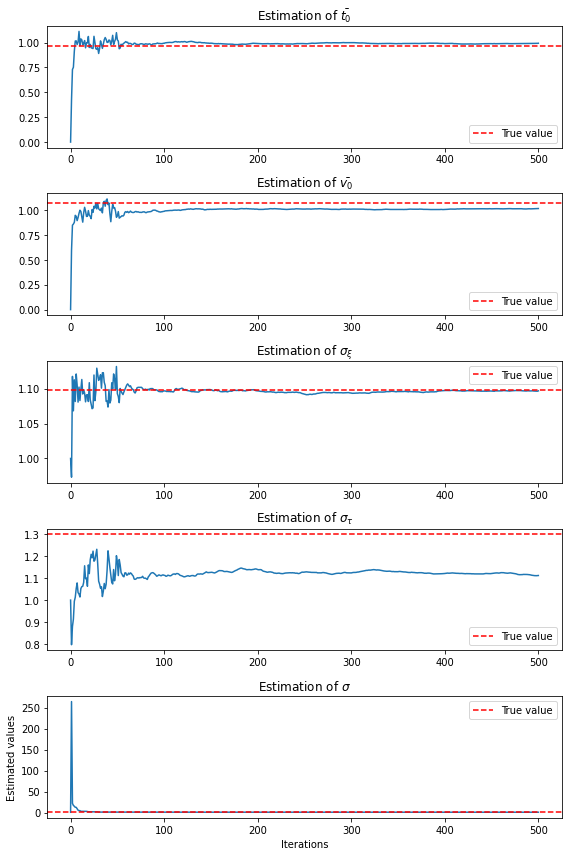

In [151]:
t0_b_est = thetas[:,0]
v0_b_est = thetas[:,1]
sigma_xi_est = thetas[:,2]
sigma_tau_est = thetas[:,3]
sigma_est = thetas[:,4]

iterations = thetas.shape[0]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 12))
abscisse = np.arange(iterations)



# Create Q-Q plots
plot_t0 = axs[0].plot(abscisse,t0_b_est)
plot_v0 = axs[1].plot(abscisse,v0_b_est)
plot_sigma_xi = axs[2].plot(abscisse,sigma_xi_est)
plot_sigma_tau = axs[3].plot(abscisse,sigma_tau_est)
plot_sigma = axs[4].plot(abscisse,sigma_est)


axs[0].set_title(r'Estimation of $\bar{t_0}$')
axs[1].set_title(r'Estimation of $\bar{v_0}$')
axs[2].set_title(r'Estimation of $\sigma_{\xi}$')
axs[3].set_title(r'Estimation of $\sigma_{\tau}$')
axs[4].set_title(r'Estimation of $\sigma$')


# Add horizontal lines for true values
axs[0].axhline(y=t0_b[0], color='red', linestyle='--', label='True value')
axs[1].axhline(y=v0_b[0], color='red', linestyle='--', label='True value')
axs[2].axhline(y=sigma_xi, color='red', linestyle='--', label='True value')
axs[3].axhline(y=sigma_tau, color='red', linestyle='--', label='True value')
axs[4].axhline(y=sigma, color='red', linestyle='--', label='True value')


# Add legend
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Estimated values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [152]:
np.random.seed(0)
@njit
def MHwG_block_zi(zi,z_pop,y,theta,max_iter,sigma_propre):
    
    taux_acceptation = np.zeros(N)

    z = np.concatenate((z_pop,zi))

    for l in range(N):

        accepte = 0
        z_l = np.copy(z)

        for k in range(max_iter):
            z_l[2+l] = z[2+l] + np.random.normal(0,sigma_propre)
            z_l[l+N+2] = z[l+N+2] + np.random.normal(0,sigma_propre)
        
            log_ratio = np.dot((S_function(y,z_l) - S_function(y,z)),psi(theta))
            
            u = np.random.rand()
            if np.log(u) < min(0,log_ratio):
                z[l+2] = z_l[l+2]
                z[l+N+2] = z_l[l+N+2]
                accepte+=1
        
        taux_acceptation[l] = accepte / max_iter

    return z[2:], taux_acceptation


In [153]:
np.random.seed(0)
z_i, accept_rate_zi = MHwG_block_zi(np.zeros(2*N),real_z[:2],y_i,real_theta,10000,0.05)

In [154]:
accept_rate_zi

array([0.1931, 0.2644, 0.7097, 0.2993, 0.1084, 0.5689, 0.5344, 0.6156,
       0.5156, 0.2609, 0.3922, 0.1091, 0.6627, 0.5041, 0.8062, 0.2676,
       0.5607, 0.4646, 0.8039, 0.1838, 0.3165, 0.1602, 0.5635, 0.0718,
       0.1308, 0.2579, 0.4236, 0.1087, 0.6364, 0.1331, 0.6562, 0.5652,
       0.5922, 0.4604, 0.428 , 0.309 , 0.8549, 0.4706, 0.4374, 0.0588,
       0.4298, 0.6188, 0.4212, 0.9215, 0.1588, 0.327 , 0.5149, 0.3383,
       0.6376, 0.4677, 0.6086, 0.1593, 0.788 , 0.9479, 0.484 , 0.8639,
       0.5706, 0.8102, 0.2709, 0.7137, 0.2061, 0.5157, 0.7606, 0.0839,
       0.017 , 0.4   , 0.5737, 0.2147, 0.801 , 0.1413, 0.734 , 0.719 ,
       0.2901, 0.4163, 0.8232, 0.5887, 0.793 , 0.2498, 0.7796, 0.3561,
       0.5214, 0.2723, 0.157 , 0.4691, 0.8062, 0.7824, 0.8298, 0.3747,
       0.107 , 0.6118, 0.3478, 0.5382, 0.7977, 0.5836, 0.0902, 0.6126,
       0.3331, 0.8302, 0.1737, 0.4495])

In [155]:
np.linalg.norm(z_i-real_z[2:])

8.638588170091632

In [156]:
np.random.seed(0)

@njit
def MHwG_block_zpop(zi,z_pop,y,theta,max_iter,sigma_propre):
    
    taux_acceptation = 0

    z = np.concatenate((z_pop,zi))
    accepte = 0

    z0 = np.copy(z)

    for k in range(max_iter):
            z0[0] = z[0] + np.random.normal(0,sigma_propre)
            z0[1] = z[1] + np.random.normal(0,sigma_propre)
        
            log_ratio = np.dot((S_function(y,z0) - S_function(y,z)),psi(theta))
            
            u = np.random.rand()
            if np.log(u) < min(0,log_ratio):
                z[0] = z0[0]
                z[1] = z0[1]
                accepte+=1
        
    taux_acceptation = accepte / max_iter

    return z[:2], taux_acceptation

In [157]:
z_pop, accept_rate_zpop = MHwG_block_zpop(real_z[2:],real_z[:2],y_i,real_theta,10000,0.2)

In [158]:
np.linalg.norm(z_pop[:2]-z_pop)

0.0

In [159]:
accept_rate_zpop

0.2961

In [161]:
np.random.seed(0)

@njit
def Block_HMwG_SAEM(y,theta_init,z_init,max_iter,N_b,alph_burn,sigma_propre,MH_steps):
    #Initialization
    S = np.zeros(6)
    step_sizes = np.ones(max_iter)
    step_sizes[(N_b+1):] = 1/((np.arange(N_b+1,max_iter) - N_b)**alph_burn)

    theta = theta_init
    z = z_init

    thetas = np.zeros((max_iter+1,5))
    thetas[0,:] = theta
    

    for k in range(max_iter):
        #Expectation step
        
        zpop,zi = z[:2],z[2:]
        zpop, accept_rate_zpop = MHwG_block_zpop(zi,zpop,y,theta,MH_steps,sigma_propre)
        zi, accept_rate_zi = MHwG_block_zi(zi,zpop,y,theta,MH_steps,sigma_propre)
        print("Mean acceptation rate for zi : ",np.mean(accept_rate_zi))
        print("Mean acceptation rate for zpop : ",accept_rate_zpop)
        z = np.concatenate((zpop,zi))
        
        
        S += step_sizes[k] * ( S_function(y,z) - S)

        #Maximization step
        log_t0_b = np.log(S[0]/(sigma_t0**2) + t0_bb/(s_t0**2) ) - np.log( 1/(s_t0**2) + 1/(sigma_t0**2)  )
        log_v0_b = np.log(S[1]/(sigma_v0**2) + v0_bb/(s_v0**2) ) - np.log( 1/(s_v0**2) + 1/(sigma_v0**2)  )
        log_sigma_ksi = (1/2) * ( np.log(v**2 + S[2]*N ) - np.log(m+2+N)  )
        log_sigma_tau = (1/2) * ( np.log(v**2 + S[3]*N ) - np.log(m+2+N)  )
        log_sigma = (1/2) * ( np.log(v**2 + S[4]*N*k_individual) - np.log(m+2+N*k_individual)  )
        # local_t0_b = (S[0]/(sigma_t0**2) + t0_bb/(s_t0**2)) / (1/(s_t0**2) + 1/(sigma_t0**2))
        # local_v0_b = (S[1]/(sigma_v0**2) + v0_bb/(s_v0**2)) / (1/(s_v0**2) + 1/(sigma_v0**2))
        # local_sigma_ksi = np.sqrt( (v**2 + S[2]*N )  / (m+2+N) )
        # local_sigma_tau = np.sqrt( (v**2 + S[3]*N )  / (m+2+N) )
        # local_sigma = np.sqrt( (v**2 + S[4]*N*k_individual )  / (m+2+N*k_individual) )

        #theta = np.array([local_t0_b,local_v0_b,local_sigma_ksi,local_sigma_tau,local_sigma])
       
        theta = np.exp(np.array([log_t0_b,log_v0_b,log_sigma_ksi,log_sigma_tau,log_sigma]))
        thetas[(k+1),:] = theta
    
    return theta , thetas

In [163]:
estimated_theta, thetas = Block_HMwG_SAEM(y_i,init_theta,np.zeros(2*N+2),500,50,0.75,0.1,20)

Mean acceptation rate for zi :  0.428
Mean acceptation rate for zpop :  0.4
Mean acceptation rate for zi :  0.36300000000000004
Mean acceptation rate for zpop :  0.6
Mean acceptation rate for zi :  0.31949999999999995
Mean acceptation rate for zpop :  0.2
Mean acceptation rate for zi :  0.3195000000000001
Mean acceptation rate for zpop :  0.6
Mean acceptation rate for zi :  0.3395
Mean acceptation rate for zpop :  0.35
Mean acceptation rate for zi :  0.3254999999999999
Mean acceptation rate for zpop :  0.5
Mean acceptation rate for zi :  0.314
Mean acceptation rate for zpop :  0.55
Mean acceptation rate for zi :  0.30800000000000005
Mean acceptation rate for zpop :  0.5
Mean acceptation rate for zi :  0.3225
Mean acceptation rate for zpop :  0.5
Mean acceptation rate for zi :  0.31049999999999994
Mean acceptation rate for zpop :  0.55
Mean acceptation rate for zi :  0.29700000000000015
Mean acceptation rate for zpop :  0.5
Mean acceptation rate for zi :  0.31299999999999994
Mean accept

In [164]:
estimated_theta

array([0.99330513, 1.00566061, 1.0929226 , 1.12790498, 1.11913776])

In [165]:
np.linalg.norm(real_theta-estimated_theta)

0.23764746243382856

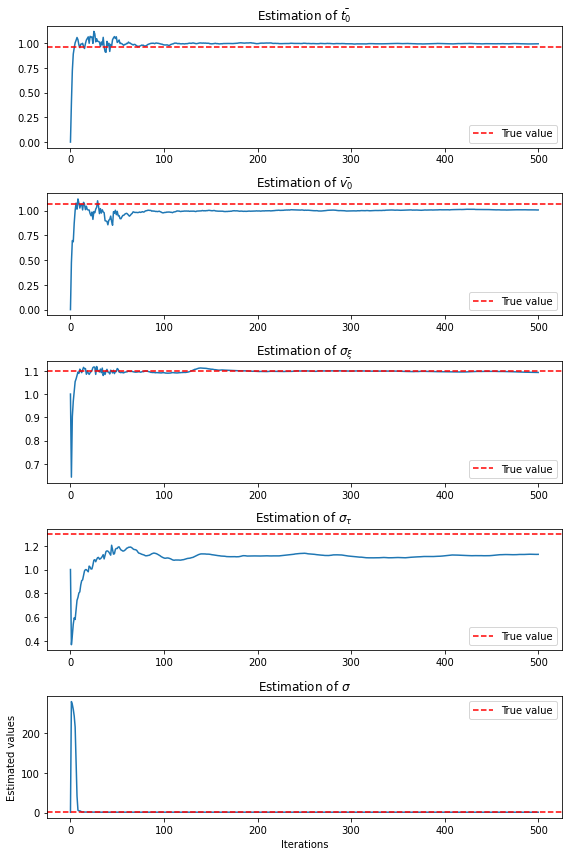

In [166]:
t0_b_est = thetas[:,0]
v0_b_est = thetas[:,1]
sigma_xi_est = thetas[:,2]
sigma_tau_est = thetas[:,3]
sigma_est = thetas[:,4]

iterations = thetas.shape[0]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 12))
abscisse = np.arange(iterations)



# Create Q-Q plots
plot_t0 = axs[0].plot(abscisse,t0_b_est)
plot_v0 = axs[1].plot(abscisse,v0_b_est)
plot_sigma_xi = axs[2].plot(abscisse,sigma_xi_est)
plot_sigma_tau = axs[3].plot(abscisse,sigma_tau_est)
plot_sigma = axs[4].plot(abscisse,sigma_est)


axs[0].set_title(r'Estimation of $\bar{t_0}$')
axs[1].set_title(r'Estimation of $\bar{v_0}$')
axs[2].set_title(r'Estimation of $\sigma_{\xi}$')
axs[3].set_title(r'Estimation of $\sigma_{\tau}$')
axs[4].set_title(r'Estimation of $\sigma$')


# Add horizontal lines for true values
axs[0].axhline(y=t0_b[0], color='red', linestyle='--', label='True value')
axs[1].axhline(y=v0_b[0], color='red', linestyle='--', label='True value')
axs[2].axhline(y=sigma_xi, color='red', linestyle='--', label='True value')
axs[3].axhline(y=sigma_tau, color='red', linestyle='--', label='True value')
axs[4].axhline(y=sigma, color='red', linestyle='--', label='True value')


# Add legend
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Estimated values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Exercise 2: Multiplicative Hasting-Metropolis


In [45]:
#Multiplicative Hasting-Metropolis Sampler

def mult_HM(pi,x0,max_iter):

    x = x0
    nb_accepetes = 0

    for i in range(max_iter):
        epsilon = (np.random.rand() * 2) - 1
        b = np.random.randint(2)
        y = b*epsilon*x + (1-b) * x/epsilon
        if np.linalg.norm(y) < 1e-6 :#y too close to 0, so we set the acceptation ratio to 0
            log_ratio = -np.inf
        else :
            log_ratio = np.log(pi(y)) + np.log(abs(y)) - np.log(pi(x)) - np.log(abs(x))
        u = np.random.rand()
        if np.log(u) <= min(0.,log_ratio):
            x = y
            nb_accepetes+=1
    
    return x


C:\Users\yokoz\AppData\Local\Temp/ipykernel_30500/786036401.py:15: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(pi(y)) + np.log(abs(y)) - np.log(pi(x)) - np.log(abs(x))


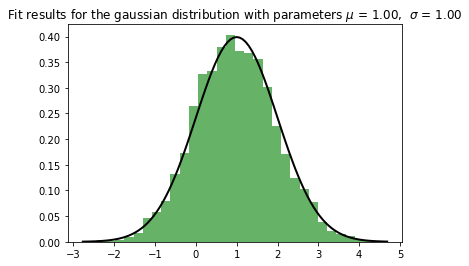

In [65]:
#If we try with the univariate gaussian distribution

x0 = 0.1

pi = lambda x : norm.pdf(x,loc=1,scale=1)

sampled_points_gaussian = []

for _ in range(5000):
    sampled_points_gaussian.append(mult_HM(pi,x0,30))

# Plot the histogram
plt.hist(sampled_points_gaussian, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF using the fitted parameters
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, loc=1,scale=1)
plt.plot(x, p, 'k', linewidth=2)

# Show the plot
plt.title(r'Fit results for the gaussian distribution with parameters $\mu$ = %.2f,  $\sigma$ = %.2f' % (1, 1))
plt.show()

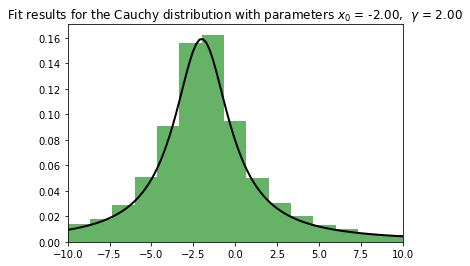

In [168]:
#The method still works for distribution with heavier tails like the Cauchy distribution
#If we try with the univariate gaussian distribution
np.random.seed(0)
x0 = 0.1

pi = lambda x : cauchy.pdf(x,loc=-2,scale=2)

sampled_points_cauchy = []

for _ in range(5000):
    sampled_points_cauchy.append(mult_HM(pi,x0,30))

hist_range=(-10,10)

# Plot the histogram
plt.hist(sampled_points_cauchy, bins=15, range=hist_range,density=True, alpha=0.6, color='g')

# Plot the PDF using the fitted parameters
xmin, xmax = hist_range
x = np.linspace(xmin, xmax, 100)
p = cauchy.pdf(x, loc=-2,scale=2)
plt.plot(x, p, 'k', linewidth=2)
plt.xlim(hist_range)

# Show the plot
plt.title(r'Fit results for the Cauchy distribution with parameters $x_0$ = %.2f,  $\gamma$ = %.2f' % (-2, 2))
plt.show()


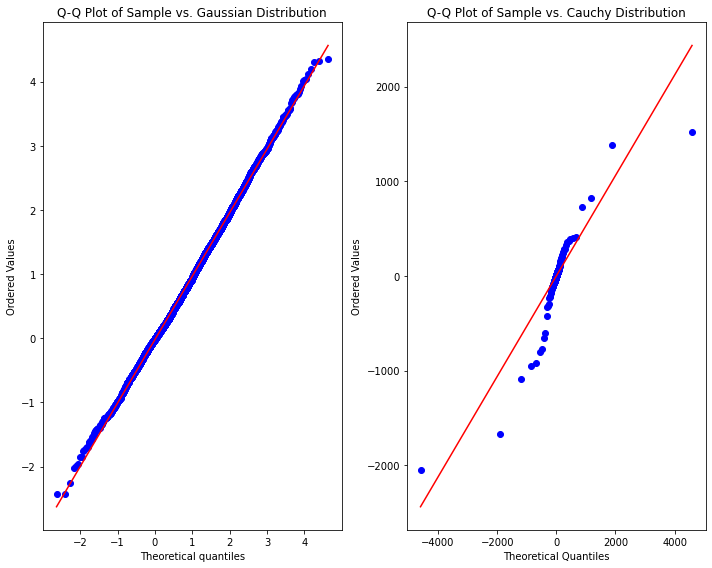

In [169]:
#We can do a qq-plot to compare the quantiles of the sample distribution with those of the theoretical distribution

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

normal_qq_plot = probplot(sampled_points_gaussian, dist=norm,sparams=(1,1), plot=axs[0])
cauchy_qq_plot = probplot(sampled_points_cauchy, dist=cauchy,sparams=(-2,2), plot=axs[1])

axs[0].set_title('Q-Q Plot of Sample vs. Gaussian Distribution')
axs[1].set_title('Q-Q Plot of Sample vs. Cauchy Distribution')


plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

# Adjust layout
plt.tight_layout()

plt.show()
